In [17]:
import pandas as pd
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import corpus
from string import punctuation
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score

from scipy.sparse import hstack

In [18]:
# Data Loading
question_df = pd.read_csv("Questions.csv", encoding="ISO-8859-1")
tag_df = pd.read_csv("Tags.csv", encoding="ISO-8859-1", dtype={'Tag': str})

tag_df['Tag'] = tag_df['Tag'].astype(str)
grouped_tags = tag_df.groupby("Id")['Tag'].apply(lambda tag_df: ' '.join(tag_df))
grouped_tags_final = pd.DataFrame({'Id': grouped_tags.index, 'Tags': grouped_tags.values})

question_df.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)
question_df = question_df.merge(grouped_tags_final, on='Id')

# Filter high-score questions
question_df = question_df[question_df['Score'] > 5]
question_df.drop(columns=['Id', 'Score'], inplace=True)

# Clean and Prepare Tags
question_df['Tags'] = question_df['Tags'].apply(lambda x: str(x).split(', '))
flat_list = [item for sublist in question_df['Tags'].values for item in sublist]
keywords = nltk.FreqDist(flat_list)
tags_features = [word[0] for word in keywords.most_common(10)]

def most_common(tags):
    return [tag for tag in tags if tag in tags_features]

question_df['Tags'] = question_df['Tags'].apply(lambda x: most_common(x))
question_df['Tags'] = question_df['Tags'].apply(lambda x: x if len(x) > 0 else None)
question_df.dropna(subset=['Tags'], inplace=True)

question_df

,Title,Body,Tags
205,Code to ask yes/no question in javascript,<p>I could only find the function <code>confir...,[javascript]
223,Table cells larger than they are meant to be,<p>I've created a map system for a game that r...,[html css]
377,What is the best quick-read Python book out th...,<p>I am taking a class that requires Python. W...,[python]
379,duplicating jQuery datepicker,<p>The <code>datepicker</code> function only w...,[javascript jquery]
471,Writing/Using C++ Libraries,<p>I am looking for basic examples/tutorials o...,[c++]
...,...,...,...
1247925,Placeholder auto wrap inside a input field,<p>I need to put a long <code>placeholder</cod...,[html css]
1249431,Log.wtf vs. Unhandled Exception,"<p>I just learned about <a href=""https://devel...",[android]
1251020,Optimizing the use of arguments inside a function,"<p>In an interview test, for the following cod...",[c++]
1256924,How does a Java if statement work when it has ...,"<p>Why does this if statement, with an assignm...",[java]


In [19]:
# Text Cleaning
nltk.download('stopwords')
nltk.download('wordnet')

token = ToktokTokenizer()
punct = punctuation
lemma = WordNetLemmatizer()
stop_words = set(corpus.stopwords.words("english"))

def clean_text(text):
    text = text.lower().strip()
    text = BeautifulSoup(text, "html.parser").get_text()
    words = token.tokenize(text)
    words = [lemma.lemmatize(w) for w in words if w not in stop_words and w not in punct]
    return ' '.join(words)

question_df['Body'] = question_df['Body'].apply(clean_text)
question_df['Title'] = question_df['Title'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lixin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lixin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\lixin\AppData\Local\Temp\ipykernel_45016\3008201576.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [20]:
# Vectorization
X1 = question_df['Body']
X2 = question_df['Title']
y = question_df['Tags']

multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

vectorizer_X1 = TfidfVectorizer(max_features=500)
vectorizer_X2 = TfidfVectorizer(max_features=500)

X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)
X_tfidf = hstack([X1_tfidf, X2_tfidf])

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size=0.2, random_state=0)


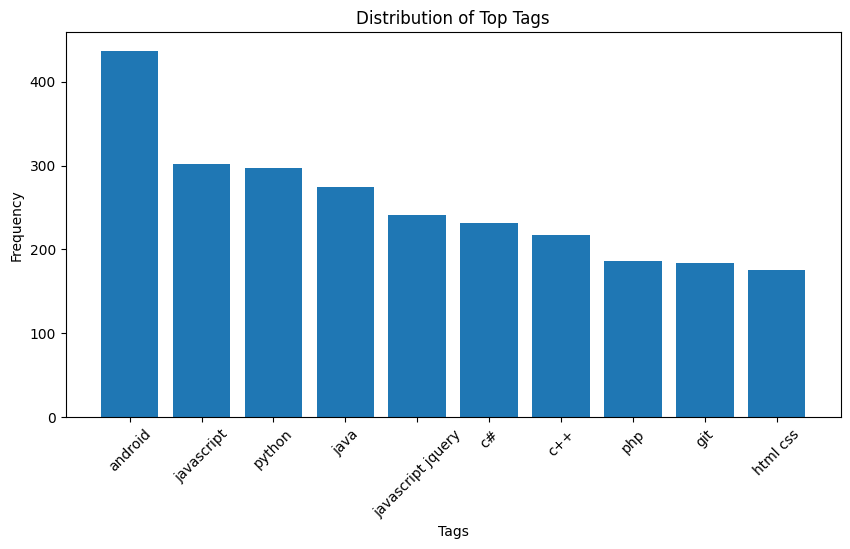

In [21]:
# Calculate tag counts directly for the filtered top tags
tag_counts = dict(zip(multilabel_binarizer.classes_, y_bin.sum(axis=0)))

# Only include the top tags from tags_features
top_tag_counts = {tag: tag_counts.get(tag, 0) for tag in tags_features}

# Plot Distribution of Top Tags
plt.figure(figsize=(10, 5))
plt.bar(top_tag_counts.keys(), top_tag_counts.values())
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Distribution of Top Tags')
plt.xticks(rotation=45)
plt.show()

In [22]:
# Train
classi = LogisticRegression()
clf = OneVsRestClassifier(classi)
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [23]:
# Evaluate on Test Set
y_pred = clf.predict(X_test)
ham = hamming_loss(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


print("Test Results:")
print(f"Hamming Loss: {ham:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")

Test Results:
Hamming Loss: 0.0472
Precision: 0.9610
Recall: 0.5442
F1-Score: 0.6803


In [24]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    question_df, y_bin, test_size=0.2, random_state=0
)

predicted_tags = multilabel_binarizer.inverse_transform(y_pred)
actual_tags = multilabel_binarizer.inverse_transform(y_test)

results_df = pd.DataFrame({
    'Body': X_test_df['Body'].values,
    'Title': X_test_df['Title'].values,
    'Actual Tags': actual_tags,
    'Predicted Tags': predicted_tags
})

# Display a few rows of predictions
results_df.sample(10)

,Body,Title,Actual Tags,Predicted Tags
115,created local branch like git branch group_con...,git pulling,"(git,)","(git,)"
381,simple web application. created server rest ap...,jquery ajax get response data error,"(javascript jquery,)","(javascript jquery,)"
168,eclipse 3.5 -- >window -- >android sdk avd man...,-unzip failed ... access denied- error adding ...,"(android,)","(android,)"
169,writing android application us several 3d mode...,increase heap size android application,"(android,)","(android,)"
253,right facebook want throw ugly div top page di...,append element top body jquery,"(javascript jquery,)","(javascript jquery,)"
121,list card suit arbitrary order like suit h c w...,python quick way return list without specific ...,"(python,)","(python,)"
292,one major challenge java developer try keep pa...,find new java technology tool specification,"(java,)","(java,)"
126,possible duplicate python package/module manag...,equivalent gem python,"(python,)","(python,)"
363,let say file. write hello tab alex,write tab python,"(python,)",()
397,ubuntu machine php -v php 5.5.10-1~dotdeb.1 cl...,exit 1 file result script status code 0,"(php,)","(php,)"
